In [1]:
!unzip dataset_autoencoder_64.zip

Archive:  dataset_autoencoder_64.zip
  inflating: test_set_64.bin         
  inflating: train_set_64.bin        


In [2]:
!pip install --quiet optuna

In [3]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import notebook, tqdm # this module is useful to plot progress bars
from sklearn.decomposition import PCA

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torchvision import transforms
import torchvision
import optuna

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")
torch.manual_seed(0)

Training device: cuda


In [5]:
train_path = 'train_set_64.bin'
test_path = 'test_set_64.bin'

train_raw = np.fromfile(train_path, dtype='float32')
test_raw = np.fromfile(test_path, dtype='float32')
print(np.shape(train_raw), np.shape(test_raw))

train_set = np.reshape(train_raw, (np.shape(train_raw)[0]//64,64))
test_set = np.reshape(test_raw, (np.shape(test_raw)[0]//64,64))
print(np.shape(train_set), np.shape(test_set))

# convert in dataframe
train_set = pd.DataFrame(train_set)
test_set = pd.DataFrame(test_set)
train_set

(46288128,) (75180800,)
(723252, 64) (1174700, 64)


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.004407,0.001996,0.004554,0.003585,0.000658,0.002856,0.005254,0.020954,-0.000037,0.008043,...,0.029766,0.068834,0.029607,-0.006064,0.035976,0.047604,-0.003587,-0.003266,0.009080,0.004765
1,-0.003536,-0.000899,0.003937,0.000953,0.014653,0.022780,0.015201,0.025493,-0.000738,0.041573,...,0.035949,0.026542,-0.011818,0.007160,0.025521,0.028424,0.000554,-0.004372,0.001171,0.005567
2,0.009644,0.001529,0.009644,0.004456,0.023019,-0.009848,0.032693,0.020424,-0.001789,0.025646,...,0.026936,0.061142,0.031942,-0.082045,0.038574,0.084142,0.002822,-0.004524,0.002922,0.004601
3,0.004933,0.001614,0.005432,0.002594,0.006627,0.008386,0.010936,0.033493,0.000318,0.006081,...,0.015463,0.032104,0.014343,-0.002371,0.037800,0.045044,0.006889,-0.002155,0.007436,0.005978
4,-0.000324,0.001745,0.009577,0.003259,-0.019881,0.001922,0.027535,0.003389,0.003554,-0.001029,...,0.068941,0.031453,-0.006571,-0.001735,0.043383,0.025357,-0.003769,0.000540,0.004506,0.001386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723247,0.005034,-0.012831,0.005158,0.013512,0.063448,-0.003992,0.066175,0.010695,-0.008170,-0.005302,...,0.068948,0.008078,-0.009452,0.003005,0.010598,0.005187,-0.020435,-0.000143,0.020713,0.000780
723248,-0.006260,-0.003385,0.013104,0.003825,0.053800,-0.032410,0.055760,0.035608,0.021822,-0.000810,...,0.055255,0.019788,0.023667,-0.000090,0.023736,0.002647,0.000255,0.000083,0.000421,0.000364
723249,-0.003266,0.006011,0.005182,0.006590,0.051895,0.022435,0.061143,0.047817,-0.005804,0.062573,...,0.031257,0.038646,-0.043760,-0.071489,0.052292,0.071736,0.001733,-0.000532,0.001804,0.000786
723250,0.001007,0.000316,0.001859,0.006791,0.042425,0.000626,0.055282,0.037178,0.039485,0.016713,...,0.061032,0.004027,0.024515,-0.002136,0.024710,0.002564,0.000197,0.000027,0.000197,0.000045


In [9]:
class EncoderConv(nn.Module):
    
    def __init__(self, encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(4, conv1_ch, 3, stride=1, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(conv1_ch, conv2_ch, 3, stride=1, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(conv2_ch, conv3_ch, 3, stride=1, padding=0),  #make it 3x3
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(2 * 2 * conv3_ch, fc_ch),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(fc_ch, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        # print(np.shape(x))
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x


class DecoderConv(nn.Module):
    
    def __init__(self, encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, fc_ch),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(fc_ch, 2 * 2 * conv3_ch),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(conv3_ch, 2, 2))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(conv3_ch, conv2_ch, 3, stride=1, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(conv2_ch, conv1_ch, 3, stride=1, padding=1, output_padding=0),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(conv1_ch, 4, 3, stride=1, padding=1, output_padding=0)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # print(np.shape(x))
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # # Apply a sigmoid to force the output to be between 0 and 1 
        # x = torch.sigmoid(x)
        return x

In [10]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for surf_batch in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        surf_batch = surf_batch.to(device)
        # Encode data
        encoded_data = encoder(surf_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, surf_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.data))
    
    return loss.data

### Test/valuation function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for surf_batch in dataloader:
            # Move tensor to the proper device
            surf_batch = surf_batch.to(device)
            # Encode data
            encoded_data = encoder(surf_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(surf_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [6]:
class NpToTensor():
    def __call__(self, array):
        return torch.from_numpy(array)

class Surf3DReshape():
    def __call__(self, desc):
        channels = []
        for i in range(4):
            channels.append(np.reshape(desc[i:64:4], (4,4)))
        channels = np.dstack(channels)
        channels = np.transpose(channels, (2,0,1))
        return channels  

class SurfDataset(Dataset):

    def __init__(self, data, transform=None):
        self.transform = transform
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #return a nparray from the dataframe
        sample = self.data.iloc[idx,:].to_numpy()
        if self.transform:
            sample = self.transform(sample)
        return sample

composed_transform = transforms.Compose([Surf3DReshape(), NpToTensor()])
to_tensor = NpToTensor()

In [7]:
best_params = {'batch_size': 294, 'architecture': 'Conv', 'conv1_ch': 126, 'conv2_ch': 99, 'conv3_ch': 106, 'fc_ch': 59, 'lr': 0.00010881094987831417}

In [8]:
#use the full dataset for the final training
train3D_dataset = SurfDataset(train_set, transform=composed_transform)
test3D_dataset = SurfDataset(test_set, transform=composed_transform)
print(len(train3D_dataset))
print(len(test3D_dataset))

723252
1174700


In [11]:
# encoded_space_dim = best_params['encoded_space_dim']
encoded_space_dim = 16
batch_size = best_params['batch_size']
# optim = best_params['optim']
optim = 'Adam'
conv1_ch = best_params['conv1_ch']
conv2_ch = best_params['conv2_ch']
conv3_ch = best_params['conv3_ch']
fc_ch = best_params['fc_ch']
lr = best_params['lr']

train_dataloader = DataLoader(train3D_dataset, batch_size=batch_size, shuffle=True)

# initialize models
encoder = EncoderConv(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)
decoder = DecoderConv(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
if optim == 'Adam':
    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)
elif optim == 'RMSprop':
    optim = torch.optim.RMSprop(params_to_optimize, lr=lr, weight_decay=1e-5)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

# Training Loop
display = True
num_epochs = 50

train_loss_record = []
val_loss_record = []
for epoch in notebook.tqdm(range(num_epochs)):
    if display:
        print('EPOCH: %d/%d' % (epoch + 1, num_epochs))

    train_loss_batch_record = []
    ### Training (use the training function)
    train_loss_batch = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    train_loss_batch_record.append(train_loss_batch)

    if display:
        print('TRAINING - EPOCH %d/%d - loss: %f' % (epoch + 1, 
                                                     num_epochs, 
                                                     sum(train_loss_batch_record)/len(train_loss_batch_record)))

    #store losses for this epoch
    train_loss_record.append(sum(train_loss_batch_record)/len(train_loss_batch_record))

EPOCH: 1/50
TRAINING - EPOCH 1/50 - loss: 0.001290
EPOCH: 2/50
TRAINING - EPOCH 2/50 - loss: 0.000759
EPOCH: 3/50
TRAINING - EPOCH 3/50 - loss: 0.000742
EPOCH: 4/50
TRAINING - EPOCH 4/50 - loss: 0.000594
EPOCH: 5/50
TRAINING - EPOCH 5/50 - loss: 0.000871
EPOCH: 6/50
TRAINING - EPOCH 6/50 - loss: 0.000639
EPOCH: 7/50
TRAINING - EPOCH 7/50 - loss: 0.000878
EPOCH: 8/50
TRAINING - EPOCH 8/50 - loss: 0.000630
EPOCH: 9/50
TRAINING - EPOCH 9/50 - loss: 0.000578
EPOCH: 10/50
TRAINING - EPOCH 10/50 - loss: 0.000686
EPOCH: 11/50
TRAINING - EPOCH 11/50 - loss: 0.000588
EPOCH: 12/50
TRAINING - EPOCH 12/50 - loss: 0.000453
EPOCH: 13/50
TRAINING - EPOCH 13/50 - loss: 0.000925
EPOCH: 14/50
TRAINING - EPOCH 14/50 - loss: 0.000685
EPOCH: 15/50
TRAINING - EPOCH 15/50 - loss: 0.000650
EPOCH: 16/50
TRAINING - EPOCH 16/50 - loss: 0.000462
EPOCH: 17/50
TRAINING - EPOCH 17/50 - loss: 0.000492
EPOCH: 18/50
TRAINING - EPOCH 18/50 - loss: 0.000450
EPOCH: 19/50
TRAINING - EPOCH 19/50 - loss: 0.000739
EPOCH: 20/5

In [12]:
torch.save(encoder.state_dict(), 'best_encoderCNN16_big.torch')
torch.save(decoder.state_dict(), 'best_decoderCNN16_big.torch')

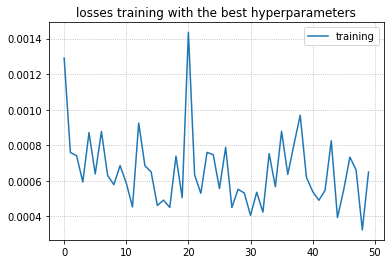

In [13]:
plt.plot(train_loss_record, label='training')
# plt.plot(val_loss_record, label='test')
plt.legend()
plt.grid(linestyle=":")
plt.title("losses training with the best hyperparameters")
plt.show()